In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore import HHRSOutputProcess
from pyincore.utils.dataprocessutil import DataProcessUtil


# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.combinedwindwavesurgebuildingdamage import CombinedWindWaveSurgeBuildingDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential
from pyincore.analyses.socialvulnerability import SocialVulnerability

In [2]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
# client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_services = FragilityService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.8.0


## Combined Building Damage

### Wind building damage for Galveston, TX using Hurricane Ike

In [3]:
hazard_type = "hurricane"

# Galveston Hurricane Ike
hazard_id = "5fa5a228b6429615aeea4410"

# Galveston inventory data
bldg_dataset_id = "63053ddaf5438e1f8c517fed"

# Building Wind Fragility mapping
mapping_id = "62fef3a6cef2881193f2261d"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [4]:
# wind building damage
w_bldg_dmg = BuildingDamage(client)
w_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
w_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
w_bldg_dmg.set_parameter("result_name", "Galveston-wind-dmg")
w_bldg_dmg.set_parameter("hazard_type", hazard_type)
w_bldg_dmg.set_parameter("hazard_id", hazard_id)
w_bldg_dmg.set_parameter("num_cpu", 8)
w_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### Surge-Wave building damage for Galveston, TX using Hurricane Ike

In [5]:
# Surge-wave mapping
mapping_id = "6303e51bd76c6d0e1f6be080"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [6]:
# surge-wave building damage
sw_bldg_dmg = BuildingDamage(client)
sw_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
sw_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
sw_bldg_dmg.set_parameter("result_name", "Galveston-sw-dmg")
sw_bldg_dmg.set_parameter("hazard_type", hazard_type)
sw_bldg_dmg.set_parameter("hazard_id", hazard_id)
sw_bldg_dmg.set_parameter("num_cpu", 8)
sw_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### Flood building damage for Galveston, TX using Hurricane Ike

In [7]:
# flood mapping
mapping_id = "62fefd688a30d30dac57bbd7"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [8]:
# flood building damage
f_bldg_dmg = BuildingDamage(client)
f_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
f_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
f_bldg_dmg.set_parameter("result_name", "Galveston-flood-dmg")
f_bldg_dmg.set_parameter("hazard_type", hazard_type)
f_bldg_dmg.set_parameter("hazard_id", hazard_id)
f_bldg_dmg.set_parameter("num_cpu", 8)
f_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### Combine wind, wave and surge building damage

In [9]:
surge_wave_damage = sw_bldg_dmg.get_output_dataset("ds_result")
wind_damage = w_bldg_dmg.get_output_dataset("ds_result")
flood_damage = f_bldg_dmg.get_output_dataset("ds_result")

In [10]:
combined_bldg_dmg = CombinedWindWaveSurgeBuildingDamage(client)
result_name = "Galveston-combined-dmg"
combined_bldg_dmg.set_input_dataset("surge_wave_damage", surge_wave_damage)
combined_bldg_dmg.set_input_dataset("wind_damage", wind_damage)
combined_bldg_dmg.set_input_dataset("flood_damage", flood_damage)
combined_bldg_dmg.set_parameter("result_name", result_name)
combined_bldg_dmg.run_analysis()

True

In [11]:
combined_dmg = combined_bldg_dmg.get_output_dataset("ds_result")
combined_dmg_df = combined_dmg.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
combined_dmg_df.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,1815653a-7b70-44ce-8544-e975596bdf82,0.000008,4.640000e-08,3.700000e-09,0.999992,0.000008,4.270000e-08,3.700000e-09,yes
1,df63f574-8e9b-426b-aa3b-b3757cb699b5,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,no
2,a743ae24-4209-44e2-b11e-7a872f071ae9,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,no
3,59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,0.000011,7.080000e-08,5.300000e-09,0.999989,0.000011,6.550000e-08,5.300000e-09,yes
4,5cc8a749-21ca-4073-8626-4ae7332cc0dd,0.000011,7.080000e-08,5.300000e-09,0.999989,0.000011,6.550000e-08,5.300000e-09,yes


### Archetype Mapping

In [12]:
buildings = Dataset.from_data_service(bldg_dataset_id, data_service)
bldg_gdf = buildings.get_dataframe_from_shapefile()
bldg_gdf.head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,strctid,parid,struct_typ,year_built,no_stories,a_stories,b_stories,bsmt_type,sq_foot,gsq_foot,...,appr_land,appr_tot,guid,ffe_elev,g_elev,archetype,arch_wind,arch_flood,arch_sw,geometry
0,ST1815653a-7b70-44ce-8544-e975596bdf82,0,None,0,1,0,0,0,2574,0,...,0,0,1815653a-7b70-44ce-8544-e975596bdf82,10.50420,10.19940,0,1,1,1,POINT (-95.21749 29.54973)
1,STdf63f574-8e9b-426b-aa3b-b3757cb699b5,0,None,0,1,0,0,0,4280,0,...,0,0,df63f574-8e9b-426b-aa3b-b3757cb699b5,10.45690,10.15210,0,1,1,1,POINT (-95.21780 29.54901)
2,STa743ae24-4209-44e2-b11e-7a872f071ae9,0,None,0,1,0,0,0,4504,0,...,0,0,a743ae24-4209-44e2-b11e-7a872f071ae9,10.31060,10.00580,0,1,1,1,POINT (-95.21771 29.54766)
3,ST59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,0,None,0,1,0,0,0,2521,0,...,0,0,59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,9.90699,9.60219,0,1,1,1,POINT (-95.21894 29.54202)
4,ST5cc8a749-21ca-4073-8626-4ae7332cc0dd,0,None,0,1,0,0,0,2431,0,...,0,0,5cc8a749-21ca-4073-8626-4ae7332cc0dd,9.90699,9.60219,0,1,1,1,POINT (-95.21891 29.54143)


In [13]:
arch_mapping = Dataset.from_data_service("63dc1f1362b9d001e6a1b485", data_service).get_dataframe_from_csv()
arch_mapping

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,arch_wind,category,cluster
0,12.0,Critical Facilities,Critical Medical - Acute Care Hospitals
1,14.0,Critical Facilities,Emergency Operations Centers
2,11.0,Critical Facilities,Critical Government - First Responder Facilities
3,NaN,Critical Facilities,"Non-ambulatory Facilities - Prisons, nursing h..."
4,NaN,Emergency Housing,Emergency Shelters
5,NaN,Emergency Housing,Residential Housing
6,NaN,Emergency Housing,SFH and Multi-family
7,NaN,Housing / Neighborhood,Critical Retail
8,13.0,Housing / Neighborhood,Religious and Spiritual Centers
9,1.0,Housing / Neighborhood,Residential Housing


In [14]:
max_dmg_state_df = DataProcessUtil.get_max_damage_state(combined_dmg_df)
max_dmg_state_df

,guid,max_prob,max_state
0,1815653a-7b70-44ce-8544-e975596bdf82,0.999992,DS_0
1,df63f574-8e9b-426b-aa3b-b3757cb699b5,1.000000,DS_0
2,a743ae24-4209-44e2-b11e-7a872f071ae9,1.000000,DS_0
3,59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,0.999989,DS_0
4,5cc8a749-21ca-4073-8626-4ae7332cc0dd,0.999989,DS_0
...,...,...,...
172529,287bcdfd-fd10-4c97-83fb-6e1d45b890bb,1.000000,DS_0
172530,caeaf2b4-ea59-419f-a19a-fafc31e4160b,1.000000,DS_0
172531,8c3cbfa2-3e47-42c2-bdea-625e3dad719a,1.000000,DS_0
172532,1435e3e0-8e86-4ce9-b638-988918198842,1.000000,DS_0


In [15]:
ret_json = DataProcessUtil.create_mapped_dmg_result(bldg_gdf, max_dmg_state_df, arch_mapping, "max_state", "arch_wind")
ret_json

{'by_cluster': [{'category': 'Critical Facilities',
   'cluster': 'Critical Medical - Acute Care Hospitals',
   'DS_0': 13,
   'DS_1': 2,
   'DS_2': 0,
   'DS_3': 0},
  {'category': 'Critical Facilities',
   'cluster': 'Emergency Operations Centers',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Critical Facilities',
   'cluster': 'Critical Government - First Responder Facilities',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Critical Facilities',
   'cluster': 'Non-ambulatory Facilities - Prisons, nursing homes, etc.',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'Emergency Shelters',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'Residential Housing',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'SFH and Multi-family',
   'DS

## Electric Power Pole Damage

In [16]:
# EPF fragility mapping
epf_mapping_id = "62fac92ecef2881193f22613"
epf_mapping_set = MappingSet(fragility_service.get_mapping(epf_mapping_id))

epf_dmg_hurricane_galveston = EpfDamage(client)
epf_dmg_hurricane_galveston.load_remote_input_dataset("epfs", "62fc000f88470b319561b58d")
epf_dmg_hurricane_galveston.set_input_dataset('dfr3_mapping_set', epf_mapping_set)
epf_dmg_hurricane_galveston.set_parameter("result_name", "Galveston-hurricane-epf-damage")
epf_dmg_hurricane_galveston.set_parameter("fragility_key", "Non-Retrofit Fragility ID Code")
epf_dmg_hurricane_galveston.set_parameter("hazard_type", hazard_type)
epf_dmg_hurricane_galveston.set_parameter("hazard_id", hazard_id)
epf_dmg_hurricane_galveston.set_parameter("num_cpu", 8)

# Run Analysis
epf_dmg_hurricane_galveston.run_analysis()
epf_dmg_result = epf_dmg_hurricane_galveston.get_output_dataset("result")

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


## Monte Carlo Failure Probability

In [17]:
mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", combined_dmg)
mc.set_parameter("result_name", "combined_bldg_mc")
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", 10)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])
mc.run_analysis()

gal_bldg_damage_mcs_samples = mc.get_output_dataset('sample_failure_state')
gal_bldg_damage_mcs_samples_df = gal_bldg_damage_mcs_samples.get_dataframe_from_csv()
gal_bldg_damage_mcs_samples_df.head()

,guid,failure
0,1815653a-7b70-44ce-8544-e975596bdf82,"1,1,1,1,1,1,1,1,1,1"
1,df63f574-8e9b-426b-aa3b-b3757cb699b5,"1,1,1,1,1,1,1,1,1,1"
2,a743ae24-4209-44e2-b11e-7a872f071ae9,"1,1,1,1,1,1,1,1,1,1"
3,59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,"1,1,1,1,1,1,1,1,1,1"
4,5cc8a749-21ca-4073-8626-4ae7332cc0dd,"1,1,1,1,1,1,1,1,1,1"


In [18]:
mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", epf_dmg_result)
mc.set_parameter("result_name", "epf_mc")
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", 10)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])
mc.run_analysis()

gal_pole_damage_mcs_samples = mc.get_output_dataset('sample_failure_state')
gal_pole_damage_mcs_samples_df = gal_pole_damage_mcs_samples.get_dataframe_from_csv()
gal_pole_damage_mcs_samples_df.head()

,guid,failure
0,2525e200-cdc6-4fb8-9952-f17579176fd8,"1,1,1,1,1,1,1,1,1,1"
1,9180f947-26ae-40bd-85f5-83a80525f6c8,"1,1,1,1,1,1,1,1,1,1"
2,11ddc2dc-cc92-4c90-b4cc-a99b92a26f4b,"1,1,1,1,1,1,1,1,1,1"
3,9e58f196-9a2c-40b1-b722-69fa9c53c9d4,"1,1,1,1,1,1,1,1,1,1"
4,a4de2d54-b251-4a02-af0c-d12e0dc3670c,"1,1,1,1,1,1,1,1,1,1"


## Building Functionality

In [19]:
gal_bldg_func = BuildingFunctionality(client)
    
gal_bldg_func.set_input_dataset("building_damage_mcs_samples", gal_bldg_damage_mcs_samples)
gal_bldg_func.set_input_dataset("poles_damage_mcs_samples", gal_pole_damage_mcs_samples)
gal_bldg_func.load_remote_input_dataset("interdependency_dictionary", "63e5af0262d82d2f5a1058ea")

gal_bldg_func.set_parameter("result_name", "gal_mcs_functionality_probability")
gal_bldg_func.run_analysis()

gal_bldg_func_samples_df = gal_bldg_func.get_output_dataset('functionality_samples').get_dataframe_from_csv()
gal_bldg_func_samples_df.head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,building_guid,samples
0,1815653a-7b70-44ce-8544-e975596bdf82,NaN
1,df63f574-8e9b-426b-aa3b-b3757cb699b5,NaN
2,a743ae24-4209-44e2-b11e-7a872f071ae9,NaN
3,59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,NaN
4,5cc8a749-21ca-4073-8626-4ae7332cc0dd,NaN


In [20]:
df_gal_bldg_func_probability = gal_bldg_func.get_output_dataset('functionality_probability').get_dataframe_from_csv()
df_gal_bldg_func_probability = df_gal_bldg_func_probability.rename(columns={"building_guid": "guid"})
func_prob_target = 0.40
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'].isna(), 'functionality'] = 1 # Assumed to be connected to an undamaged/unanalyzed power network for now.
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] <= func_prob_target, 'functionality'] = 0 # Non-Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] > func_prob_target, 'functionality'] = 1 # Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'].isna(), 'functionality_state'] = 'Functional' # Assumed to be connected to an undamaged/unanalyzed power network for now.
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] <= func_prob_target, 'functionality_state'] = 'Non-Functional' # Non-Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] > func_prob_target, 'functionality_state'] = 'Functional' # Functional
df_gal_bldg_func_probability.head()


,guid,probability,functionality,functionality_state
0,1815653a-7b70-44ce-8544-e975596bdf82,NaN,1.0,Functional
1,df63f574-8e9b-426b-aa3b-b3757cb699b5,NaN,1.0,Functional
2,a743ae24-4209-44e2-b11e-7a872f071ae9,NaN,1.0,Functional
3,59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,NaN,1.0,Functional
4,5cc8a749-21ca-4073-8626-4ae7332cc0dd,NaN,1.0,Functional


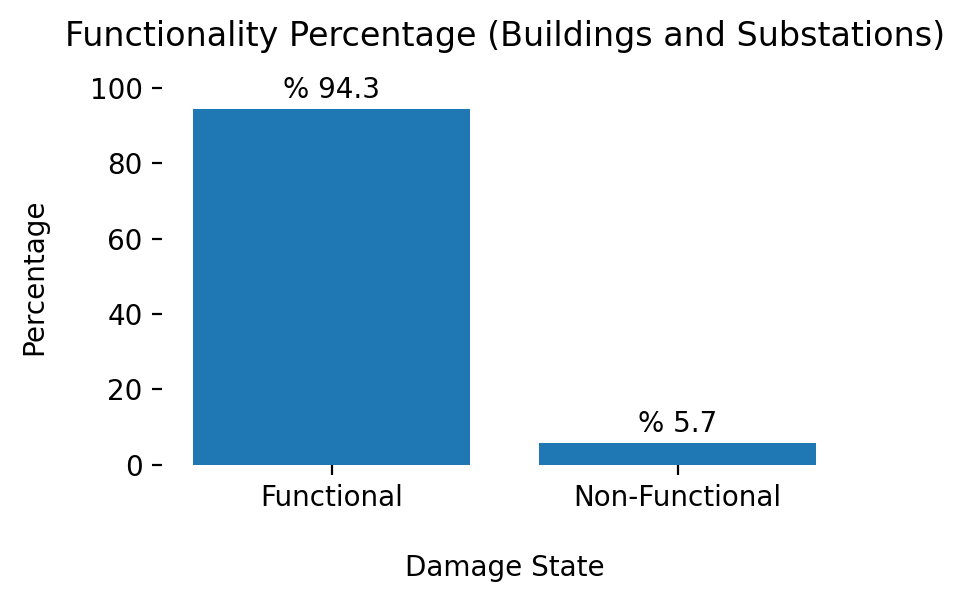

In [21]:
### Plot of the distribution of functionality state for buildings
indexes = df_gal_bldg_func_probability['functionality_state'].value_counts(normalize=True).mul(100).index.tolist()
values = df_gal_bldg_func_probability['functionality_state'].value_counts(normalize=True).mul(100).tolist()

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

bars = ax.bar(x=indexes, height=values,)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,f'% {bar.get_height() :.1f}',
            horizontalalignment='center')

fig.tight_layout()
ax.set_ylim([0,100])
ax.set_xlabel('Damage State', labelpad=15)
ax.set_ylabel('Percentage', labelpad=15)
ax.set_title('Functionality Percentage (Buildings and Substations)', pad=15)
ax.set(frame_on=False);

# CGE Placeholder

## Population Dislocation

In [22]:
pop_dis = PopulationDislocation(client)
value_loss = "60354810e379f22e16560dbd"
bg_data = "603545f2dcda03378087e708"
hua_result_id = "63ee615d62b9d001e6a2b660"

pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)
pop_dis.load_remote_input_dataset("housing_unit_allocation", hua_result_id)
pop_dis.set_input_dataset("building_dmg", combined_dmg)

result_name = "galveston-pop-disl-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)
pop_dis.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [23]:
population_dislocation_result = pop_dis.get_output_dataset("result")
population_dislocation_result_df = population_dislocation_result.get_dataframe_from_csv(low_memory=False)
population_dislocation_result_df.head()

,guid,DS_0,DS_1,DS_2,DS_3,haz_expose,huid,blockid,bgid,tractid,...,Survey,pblackbg,phispbg,d_sf,rploss_0,rploss_1,rploss_2,rploss_3,prdis,dislocated
0,2290ae5b-99e1-46d2-b6cb-f4dde1c2ed51,1.0,0.0,0.0,0.0,no,B481677201001000H001,481677201001000,481677201001,48167720100,...,2010 dec/sf1,1.726539,8.911167,1,0.002914,0.100425,0.524702,0.889881,0.0,False
1,3c985a93-c848-40c8-835a-85184f69bbb4,1.0,0.0,0.0,0.0,no,B481677201001000H002,481677201001000,481677201001,48167720100,...,2010 dec/sf1,1.726539,8.911167,1,0.006930,0.132025,0.677548,0.951019,0.0,False
2,7c6fe5f4-d96a-4304-8267-7a1dcde7ec91,1.0,0.0,0.0,0.0,no,B481677201001000H003,481677201001000,481677201001,48167720100,...,2010 dec/sf1,1.726539,8.911167,1,0.005776,0.100000,0.654935,0.941974,0.0,False
3,314a358e-186c-4a6b-9e41-d15edf4adb95,1.0,0.0,0.0,0.0,no,B481677201001000H004,481677201001000,481677201001,48167720100,...,2010 dec/sf1,1.726539,8.911167,1,0.002404,0.105851,0.436479,0.854591,0.0,False
4,b1a887d1-b151-4bce-b555-da24e0dabbf5,1.0,0.0,0.0,0.0,no,B481677201001000H005,481677201001000,481677201001,48167720100,...,2010 dec/sf1,1.726539,8.911167,1,0.003029,0.133077,0.438777,0.855511,0.0,False


## Housing Houshold Recovery Sequentials

### Social Vulnerabilities

In [24]:
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "gal_social_vulnerabilty")
social_vulnerability.load_remote_input_dataset("national_vulnerability_feature_averages", "63d178c2a011a9746c948115")
social_vulnerability.load_remote_input_dataset("social_vulnerability_demographic_factors", "63d17e81a011a9746c94811b")
social_vulnerability.run_analysis()
sv_result = social_vulnerability.get_output_dataset("sv_result")

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


### HHRS

In [25]:
# Population dislocation result aggregated to the block group level.
# Transition probability matrix per social vulnerability level.
transition_probability_matrix = "60f5e2ae544e944c3cec0794"
# Initial mass probability function for stage 0.
initial_probability_vector = "60f5e918544e944c3cec668b" # this is only for galveston???

# Create housing recovery instance
housing_recovery = HousingRecoverySequential(client)

# Load input datasets
housing_recovery.set_input_dataset("population_dislocation_block", population_dislocation_result)
housing_recovery.load_remote_input_dataset("tpm", transition_probability_matrix)
housing_recovery.load_remote_input_dataset("initial_stage_probabilities", initial_probability_vector)

# Chain with SV output
housing_recovery.set_input_dataset('sv_result', sv_result)

# Initial value to seed the random number generator to ensure replication
seed = 1111
# A size of the analysis time step.
t_delta = 1.0
# Total duration.
t_final = 90.0


# Specify the result name
result_name = "housing_recovery_result"

# Set analysis parameters
housing_recovery.set_parameter("result_name", result_name)
housing_recovery.set_parameter("seed", seed)
housing_recovery.set_parameter("t_delta", t_delta)
housing_recovery.set_parameter("t_final", t_final)

housing_recovery.run()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [26]:
HH_stagehistory_DF = housing_recovery.get_output_dataset("ds_result").get_dataframe_from_csv()
timesteps = ["1", "7", "13", "25", "49", "85"] # t0, t6, t12, t24, t48
HHRSOutputProcess.get_hhrs_stage_count(timesteps, HH_stagehistory_DF)

{'1': [11635, 331, 310, 65512, 0],
 '7': [2405, 3667, 2506, 69210, 0],
 '13': [2077, 3037, 1679, 70993, 2],
 '25': [1743, 2252, 1046, 72610, 137],
 '49': [1295, 1401, 460, 74012, 620],
 '85': [95, 79, 26, 74425, 3163]}